## Visualizing the sailed path

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id

import datetime, time
import platform
import math             
import random
import os
import pathlib
import warnings

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# OpenTNSIM
import opentnsim
import opentnsim.core as core
import opentnsim.utils

# Used for making the graph to visualize our problem
import networkx as nx  

from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

print('This notebook has been tested with OpenTNSim version {}'.format(opentnsim.__version__))

This notebook has been tested with OpenTNSim version 1.1.2


In [2]:
# Graph location
src_dir = pathlib.Path(opentnsim.__file__).parent.parent

# Graph location
location_graph = src_dir / "notebooks"
name_graph = location_graph / "Shape-Files" / "Rotterdam-Antwerpen-corridor" / "edges_2.shp"


### Create graph

**Important**: 

If you use windows and get the following error "ImportError: read_shp requires OGR: http://www.gdal.org/", you probably have [this issue](https://github.com/conda-forge/gdal-feedstock/issues/219). Solving it is possible by running the following commands in your terminal (as explained [here](https://gis.stackexchange.com/questions/294231/installing-gdal-with-anaconda)):

```bash
#Create a new virtual environment
conda create -n testgdal -c conda-forge gdal vs2015_runtime=14

#Activate virtual environment
activate testgdal

#Open Jupyter notebook
jupyer notebook
```

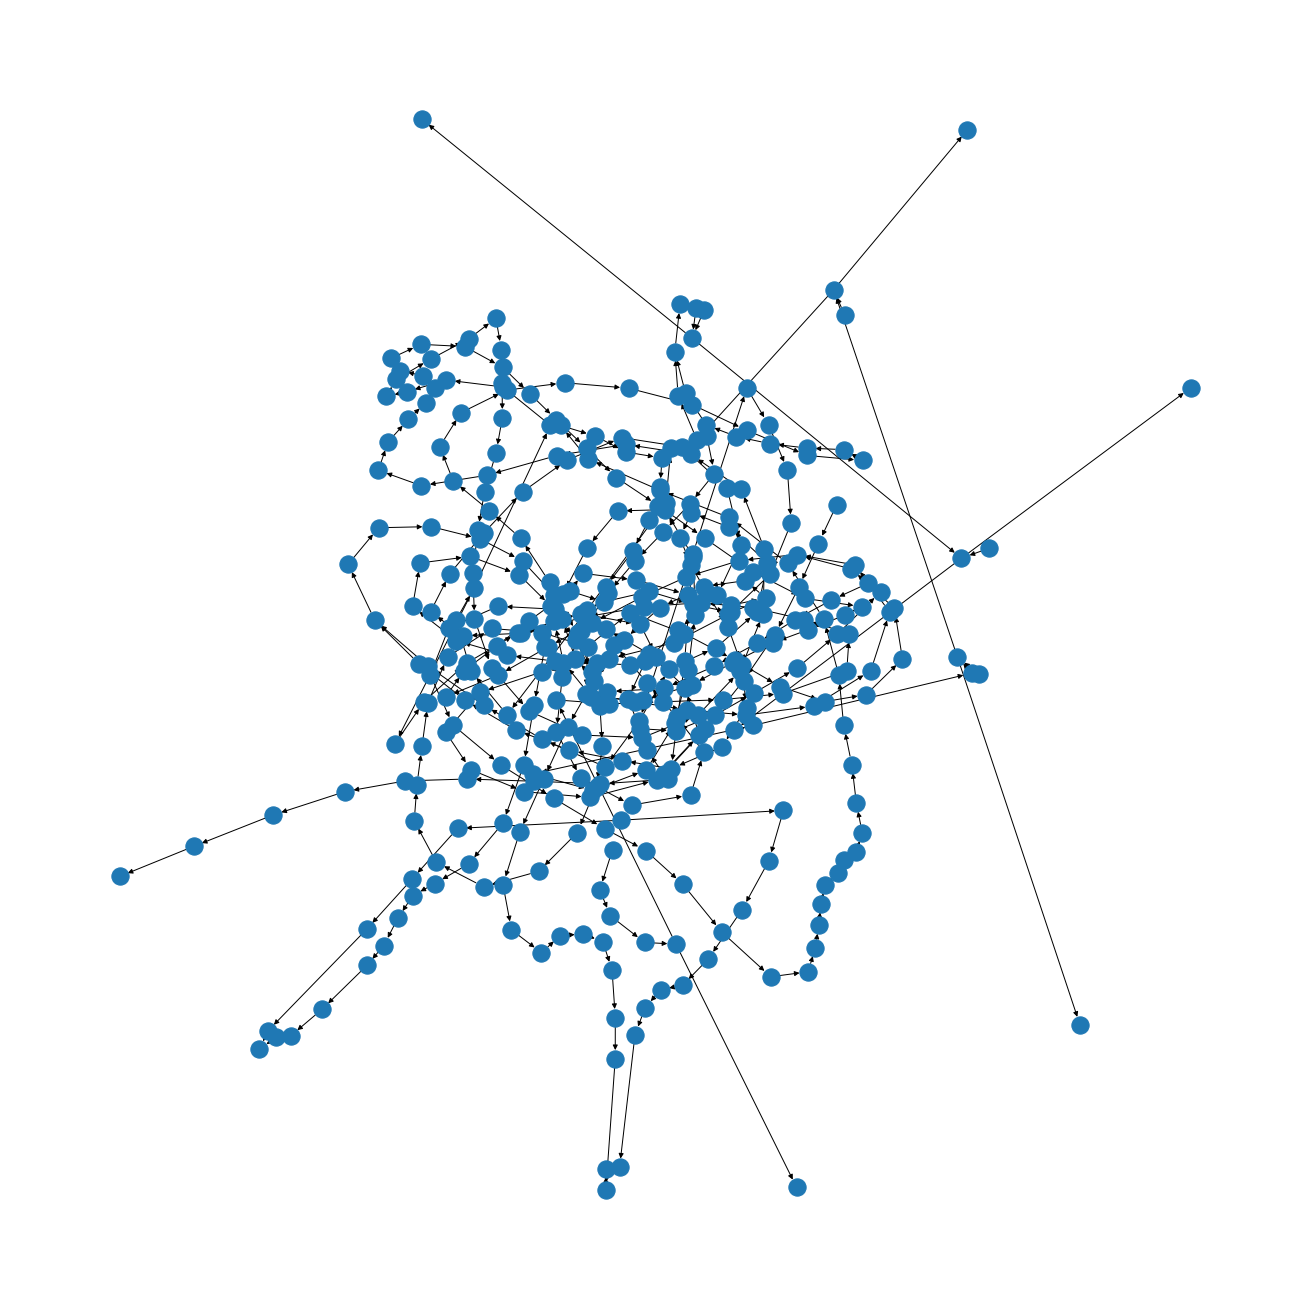

In [3]:
# Read the shape-file
FG = opentnsim.utils.read_shp(str(name_graph), simplify=True)

# Draw the shape-file to get a first impression
plt.figure(figsize=(18,18))
nx.draw(FG)

# Show the drawing
plt.show()

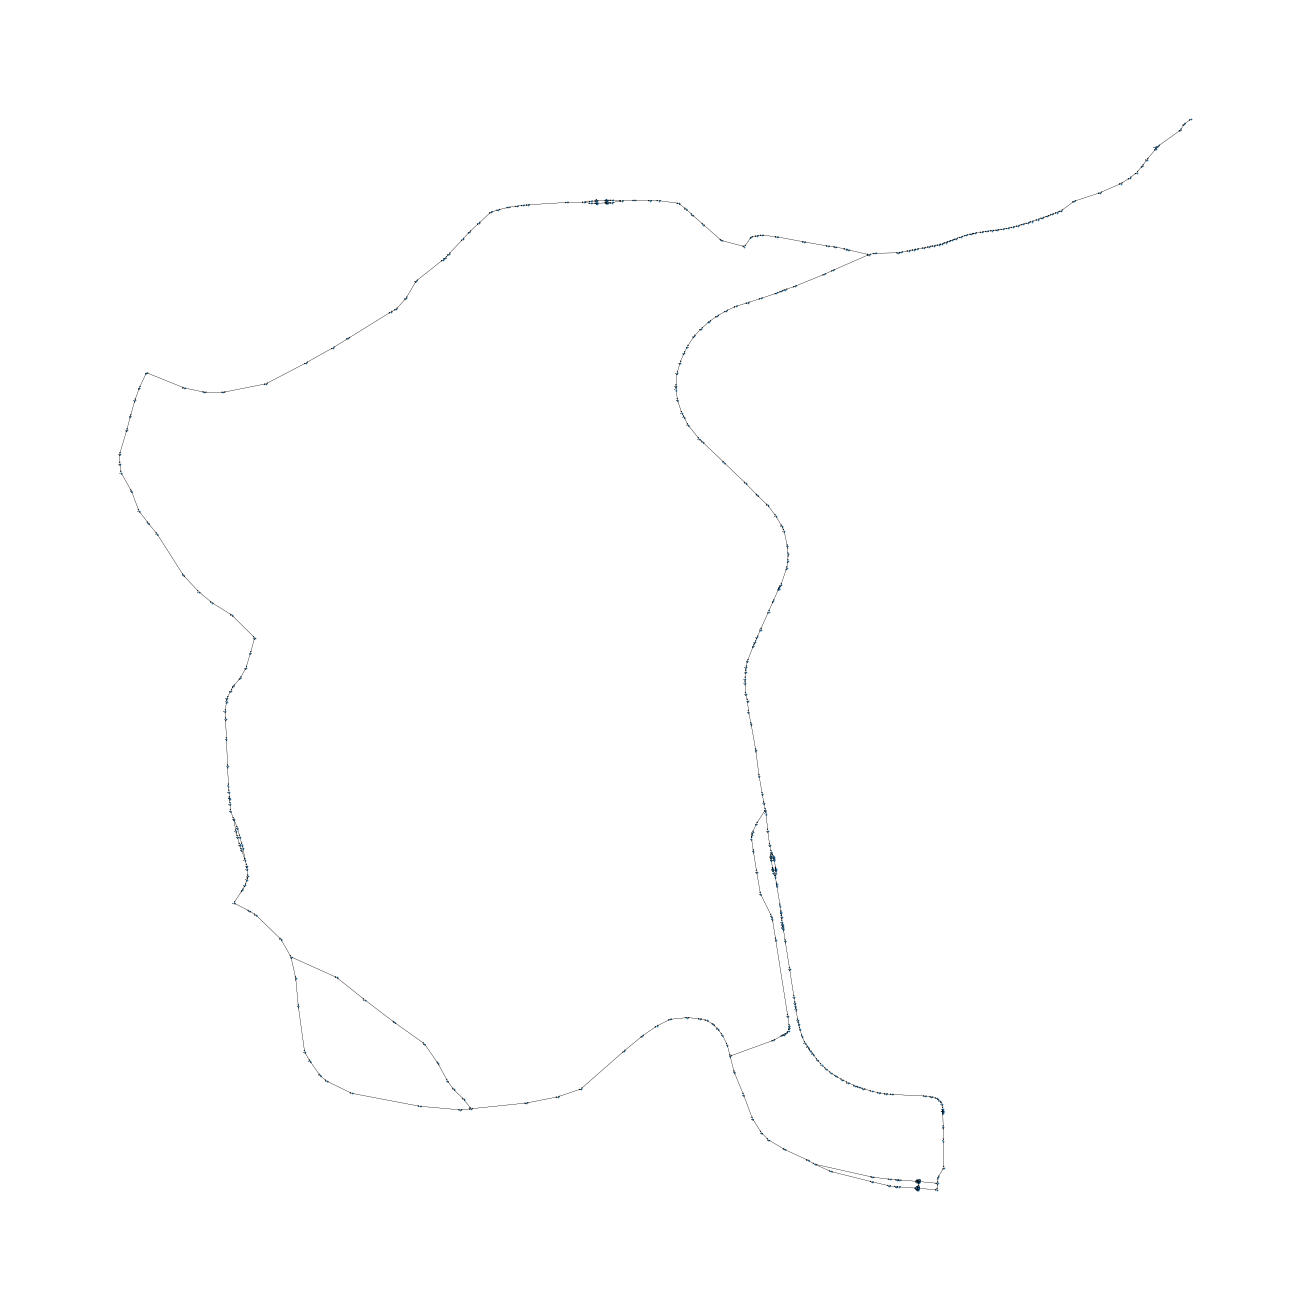

In [4]:
# calculate distance between two points
def calculate_distance(orig, dest):
    wgs84 = pyproj.Geod(ellps='WGS84')
    
    distance = wgs84.inv(shapely.geometry.shape(orig).x, shapely.geometry.shape(orig).y, 
                         shapely.geometry.shape(dest).x, shapely.geometry.shape(dest).y)[2]
    
    return distance

H_G = nx.Graph()

lat_lon_to_index = {}
edge_id_counter = 0

for i, node in enumerate(FG.nodes(data = True)):
    H_G.add_node(i, pos = node[0], 
                    name = "Node {}".format(i),
                    geometry = shapely.geometry.Point(node[0][0], node[0][1]))
    lat_lon_to_index[node[0]] = i

    
for edge in FG.edges(data=True): 
    H_G.add_edge(lat_lon_to_index[edge[0]], 
                 lat_lon_to_index[edge[1]],
                 dis= calculate_distance(nx.get_node_attributes(H_G, 'geometry')[lat_lon_to_index[edge[1]]], 
                                         nx.get_node_attributes(H_G, 'geometry')[lat_lon_to_index[edge[0]]]))

FG = H_G.to_directed()
plt.figure(figsize=(18,18))
nx.draw(FG, nx.get_node_attributes(FG, 'pos'), with_labels=True, node_size=0.5, font_size = 2, width = 0.2, arrowsize = 3)
plt.show()

### Create vessels
Vessel without graph, but with shortest path.

In [5]:
# Make a class out of mix-ins
TransportResource = type('TransportResource', 
                         (core.Identifiable, core.Movable, 
                          core.HasResource, core.Routeable,
                         core.ExtraMetadata), {})



# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

data_vessel = {"env": None,
               "name": "Vessel number 1",
               "route": None,
               "geometry": shapely.geometry.Point(0, 0),  # lon, lat
               "capacity": 1_000,
               "v": 1
}

# create the transport processing resource
vessel = TransportResource(**data_vessel)

/var/folders/fh/tcbrjg6n28b0lzjzh07b5t6m0000gn/T/ipykernel_27863/2867066792.py:22: DeprecationWarning:

Call to deprecated class Routeable. (Use Routable instead of Routeable)



### Define paths

In [6]:
# First simulation is from random node 1 to random node 2
source = 80
target = 287

path = nx.dijkstra_path(FG, source, target)


### Run simulation

In [7]:
def start(env, vessel):
    while True:
        vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
        yield from vessel.move()
        vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        
        if vessel.geometry == nx.get_node_attributes(FG, "geometry")[vessel.route[-1]]:
            break

In [8]:
# Start simpy environment
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())

# Add graph to environment
env.FG = FG

# Add environment and path to the vessel
vessel.env = env
vessel.route = path
vessel.geometry = nx.get_node_attributes(FG, "geometry")[path[0]]

# Start the simulation
env.process(start(env, vessel))
env.run()

print("Simulation of path {} took {} seconds".format(path, int(env.now)))



Simulation of path [80, 81, 94, 95, 96, 303, 74, 304, 315, 395, 383, 253, 254, 255, 88, 89, 90, 109, 287] took 1684882786 seconds


/var/folders/fh/tcbrjg6n28b0lzjzh07b5t6m0000gn/T/ipykernel_27863/2171593036.py:3: DeprecationWarning:

Call to deprecated method log_entry. (Use .log_entry_v0 instead)

/var/folders/fh/tcbrjg6n28b0lzjzh07b5t6m0000gn/T/ipykernel_27863/2171593036.py:5: DeprecationWarning:

Call to deprecated method log_entry. (Use .log_entry_v0 instead)



### Obtain vessel log information
The cel below uses the vessel log. The core function *log_entry* is used, which takes four arguments:

- **Log.** A text to describe what is logged.
- **t.** The timestamp.
- **Value.**  The value for the log (for sailing this is the distance).
- **Geometry** The location of the vessel while loggin.

In [13]:
vessel_log = pd.DataFrame.from_dict(vessel.logbook)
vessel_log.head()

,Message,Timestamp,Value,Geometry
0,Start sailing,2023-05-23 22:27:50.000000,,POINT (4.2898595 51.3462538)
1,Sailing from node 80 to node 81 start,2023-05-23 22:27:50.000000,0,POINT (4.2898595 51.3462538)
2,Sailing from node 80 to node 81 stop,2023-05-23 22:28:18.779383,0,POINT (4.2898218 51.3459962)
3,Sailing from node 81 to node 94 start,2023-05-23 22:28:18.779383,0,POINT (4.2898218 51.3459962)
4,Sailing from node 81 to node 94 stop,2023-05-23 22:36:51.014840,0,POINT (4.2825009 51.3464185)


### Visualization of path
If you get an error regarding ffmpeg use [this](https://stackoverflow.com/questions/13316397/matplotlib-animation-no-moviewriters-available) answer. You have to install ffmpeg in your Conda environment. It can be done using the following command.

```bash
#Install ffmpeg using Conda
conda install -c conda-forge ffmpeg
```

CPU times: user 23.9 s, sys: 2.1 s, total: 26 s
Wall time: 26.8 s


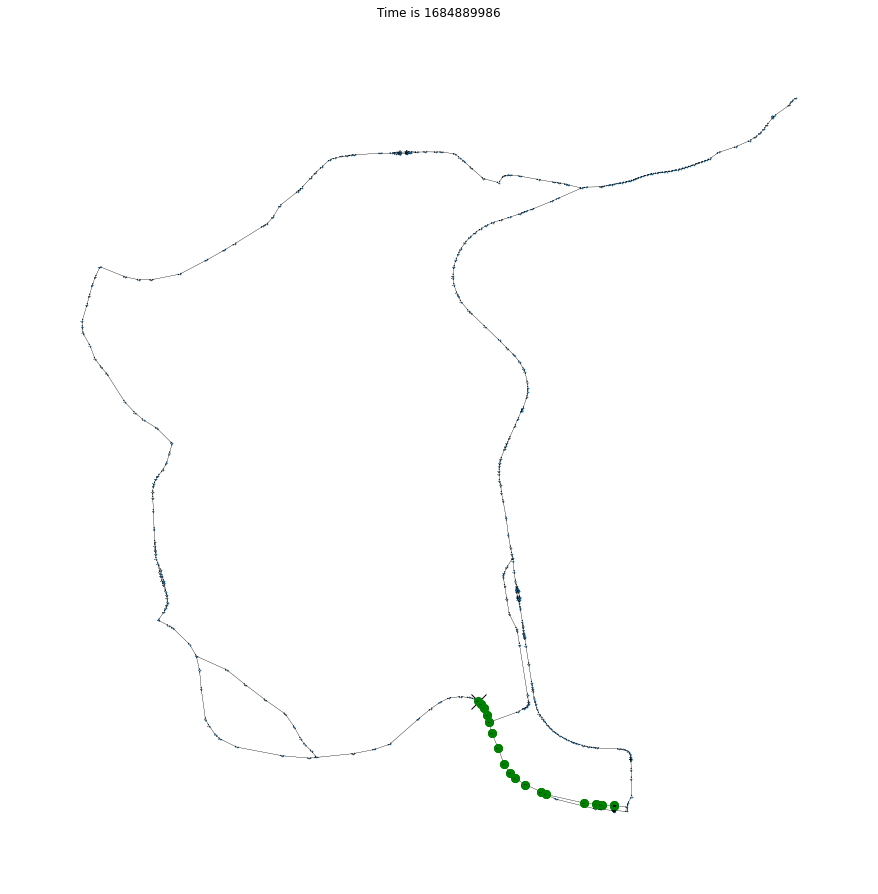

In [16]:
%%time

# Get the coordinates of every step
coordinates = []
for i in vessel_log["Geometry"]:
    coordinates.append((i.x, i.y))
    
# Get the time of every step
timesteps = []
for i in vessel_log["Timestamp"]:
    timesteps.append(i.timestamp())

# Make the animation
fig = plt.figure(figsize = [12, 12])

nx.draw(FG, nx.get_node_attributes(FG, 'pos'), 
        with_labels = True, 
        node_size = 0.5,
        font_size = 2, 
        width = 0.2, 
        arrowsize = 3)

location, = plt.plot([], [], 'kx', markersize=15)
path, = plt.plot([], [], 'go', markersize=8)
time_text = plt.title("")

def init():
    location.set_data([], [])
    path.set_data([], [])
    time_text.set_text("Time is 0")

def animate(i):
    this_x = [coordinates[i][0]]
    this_y = [coordinates[i][1]]
    
    location.set_data(this_x, this_y)
    time_text.set_text("Time is {}".format(int(timesteps[i])))
    
    if 0 < i:
        past_x = [coordinate[0] for coordinate in coordinates[:i]]
        past_y = [coordinate[1] for coordinate in coordinates[:i]]
        
        path.set_data(past_x, past_y)
    
        return location, path, time_text
    
    else:
        return location, time_text
    
        
ani = animation.FuncAnimation(fig, animate, np.arange(0, len(timesteps)), init_func=init)
ani.save('Example 06 - route.mp4', fps=5)

### Visualisation improved

In [23]:
geom_x = []
geom_y = []

for geom in vessel_log["Geometry"]:
    geom_x.append(geom.x)
    geom_y.append(geom.y)

vessel_log["Geometry - x"] = geom_x
vessel_log["Geometry - y"] = geom_y

vessel_log.head()

,Message,Timestamp,Value,Geometry,Geometry - x,Geometry - y,timestamps_t
0,Start sailing,2023-05-23 22:27:50.000000,,POINT (4.2898595 51.3462538),4.289860,51.346254,1.684881e+09
1,Sailing from node 80 to node 81 start,2023-05-23 22:27:50.000000,0,POINT (4.2898595 51.3462538),4.289860,51.346254,1.684881e+09
2,Sailing from node 80 to node 81 stop,2023-05-23 22:28:18.779383,0,POINT (4.2898218 51.3459962),4.289822,51.345996,1.684881e+09
3,Sailing from node 81 to node 94 start,2023-05-23 22:28:18.779383,0,POINT (4.2898218 51.3459962),4.289822,51.345996,1.684882e+09
4,Sailing from node 81 to node 94 stop,2023-05-23 22:36:51.014840,0,POINT (4.2825009 51.3464185),4.282501,51.346418,1.684882e+09


In [25]:
geom_x = []
geom_y = []

for geom in vessel_log["Geometry"]:
    geom_x.append(geom.x)
    geom_y.append(geom.y)

vessel_log["Geometry - x"] = geom_x
vessel_log["Geometry - y"] = geom_y

time_stamp_min = min(vessel_log["Timestamp"]).timestamp()
time_stamp_max = max(vessel_log["Timestamp"]).timestamp()

steps = int(np.floor((time_stamp_max - time_stamp_min) / 60))
steps = vessel_log.shape[0]
timestamps_t = np.linspace(time_stamp_min, time_stamp_max, steps)

times = []
for t in vessel_log["Timestamp"]:
    times.append(t.timestamp())

vessel_log["timestamps_t"] = timestamps_t
vessel_log["timestamps_x"] = np.interp(timestamps_t, times, vessel_log["Geometry - x"])
vessel_log["timestamps_y"] = np.interp(timestamps_t, times, vessel_log["Geometry - y"])

timestamps_t = vessel_log["timestamps_t"] 
timestamps_x = vessel_log["timestamps_x"]
timestamps_y = vessel_log["timestamps_y"]

CPU times: user 23.5 s, sys: 2.5 s, total: 26 s
Wall time: 23.2 s


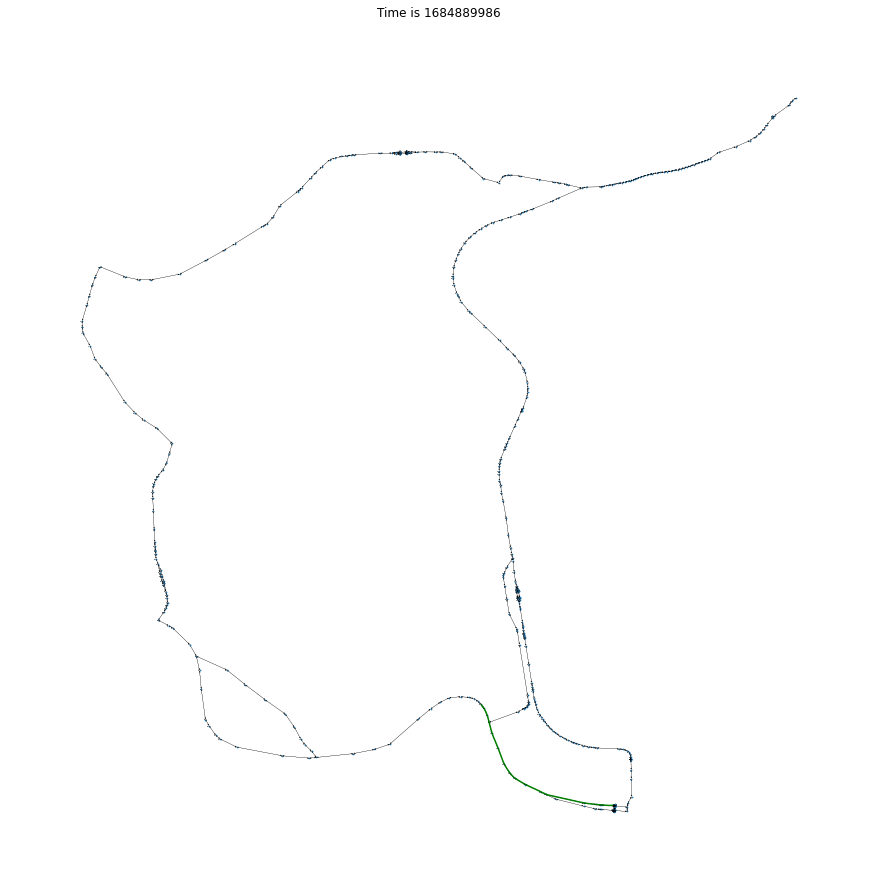

In [26]:
%%time

# Make the animation
fig = plt.figure(figsize = [12, 12])

nx.draw(FG, nx.get_node_attributes(FG, 'pos'), 
        with_labels = True, 
        node_size = 0.5,
        font_size = 2, 
        width = 0.2, 
        arrowsize = 3)

location, = plt.plot([], [], 'ko', markersize=15)
path, = plt.plot([], [], 'g')
time_text = plt.title("")

def init():
    location.set_data([], [])
    path.set_data([], [])
    time_text.set_text("Time is 0")

def animate(i):
    this_x = [timestamps_x[i]]
    this_y = [timestamps_x[i]]
    
    location.set_data(this_x, this_y)
    time_text.set_text("Time is {}".format(int(timestamps_t[i])))
    
    if 0 < i:
        past_x = [x for x in timestamps_x[:i]]
        past_y = [y for y in timestamps_y[:i]]
        
        path.set_data(past_x, past_y)
    
        return location, path, time_text
    
    else:
        return location, time_text
    
        
ani = animation.FuncAnimation(fig, animate, np.arange(0, len(timestamps_t)), init_func=init)
ani.save('Example 06 - route - improved.mp4', fps=5)